# Deep Convolutional Wasserstein GAN-gp

In [1]:
import os, glob, copy, time, math
visible_devices = [2,3]
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(i) for i in visible_devices])

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import datasets
import torchvision.transforms as transforms
from pytorch_memlab import MemReporter
from multiprocessing import Pool, cpu_count
from attrdict import AttrDict
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# カレントディレクトリをリポジトリ直下にして自家製モジュールをimport
while os.getcwd().split('/')[-1] != 'schwbert': os.chdir('..')
print('current dir:', os.getcwd())
from utils import Timer, count_params
from modules.multi_gpu import MultiGPUWrapper

core_num = 20
print(f"{core_num}/{cpu_count()} cpus are available.")

current dir: /root/schwbert
20/32 cpus are available.


In [2]:
data_dir = "../datasets/mnist"

In [3]:
config = AttrDict({
    'batch_size': 1000,
    'img_size': 32, # Convolutionalしやすいよう2の累乗へ
    'lr': 0.0002,
    'b1': 0.5,
    'b2': 0.999,
    'latent_dim': 100,
    'dtt': 10,
    'gtt': 1,
    'gp_lambda': 10,
})

config.img_shape = (1, config.img_size, config.img_size)

## データロード

In [4]:
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        data_dir,
        train=True,
        download=True,
        transform=transforms.Compose(
            # 同サイズ，平均0.5，標準偏差0.5のテンソルへtransform
            [transforms.Resize(config.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=config.batch_size,
    shuffle=True,
)
len(dataloader)

60

In [5]:
def show_img(batch, batch_id=0):
    npimg = batch[batch_id].detach().numpy()
    npimg = npimg.reshape((config.img_size, config.img_size))
    plt.imshow(npimg, cmap='gray')

## 生成器と識別器の定義

In [6]:
class DCGenerator(nn.Module):
    def __init__(self, config):
        super(DCGenerator, self).__init__()

        self.init_size = config.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(config.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img



class DCDiscriminator(nn.Module):
    def __init__(self, config):
        super(DCDiscriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [
                nn.Conv2d(in_filters, out_filters, 3, 2, 1), 
                nn.LeakyReLU(0.2, inplace=True), 
                nn.Dropout2d(0.25)
            ]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(1, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = config.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(
            nn.Linear(128 * ds_size ** 2, 1), 
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

重みの初期化関数

In [7]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

動作確認

g_out shape: torch.Size([1000, 1, 32, 32])
d_out_fake shape: torch.Size([1000, 1])
d_out_real shape: torch.Size([1000, 1])


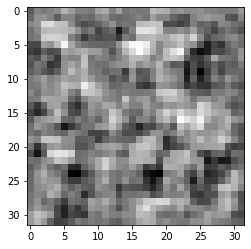

In [18]:
device = torch.device('cpu')

G = DCGenerator(config)
D = DCDiscriminator(config)

generator = iter(dataloader)
images, _ = generator.next()

z = torch.randn(config.batch_size, config.latent_dim).to(device)
g_out = G(z)
d_out_fake = D(g_out)
d_out_real = D(images)

print("g_out shape:", g_out.shape)
show_img(g_out, 0)

print("d_out_fake shape:", d_out_fake.shape)
# print("d_out_fake value:\n", d_out_fake.squeeze(-1))
print("d_out_real shape:", d_out_real.shape)
# print("d_out_real value:\n", d_out_real.squeeze(-1))

## モデルの準備

In [8]:
device = torch.device('cuda')
multi_gpu = (visible_devices != []) & (device.type == 'cuda')

G = DCGenerator(config).to(device)
D = DCDiscriminator(config).to(device)

# Gの中でノイズ作って，DataParallel通すとGの出力のBatch数がGPUの個数倍になって出てくる謎現象が発生する
# zを外で作って先にdeviceを与えてやったらうまくいった
# てかmultigpuする必要もないほど軽い
multi_gpu = True
if multi_gpu:
    print("Use Multi GPUs")
    G, D = MultiGPUWrapper(G), MultiGPUWrapper(D)

g_optim = optim.Adam(G.parameters(), lr=config.lr, betas=(config.b1, config.b2))
d_optim = optim.Adam(D.parameters(), lr=config.lr, betas=(config.b1, config.b2))

print("Network settings completed")
print("#parameters of G:", count_params(G))
print("#parameters of D:", count_params(D))

Use Multi GPUs
Network settings completed
#parameters of G: 1049985
#parameters of D: 98113


## 学習関数の定義
Wasserstein

In [9]:
def calculate_gradient_penalty(D, real, fake, gp_lambda, device):
    
    # Random Weighted AverageによりRealとFakeの中間テンソルを取得
    eta = torch.empty(len(real), 1, 1, 1).uniform_(0, 1).to(device)
    interpolates = eta * real + ((1 - eta) * fake)
    interpolates = interpolates.requires_grad_(True)

    # 中間テンソルをDに通したテンソルを取得
    d_interpolates = D(interpolates)

    # 勾配計算の終端へ与える値？を作成
    grad_outputs = torch.ones((len(real), 1)).to(device)
    grad_outputs.requires_grad = False
    
    # 勾配ペナルティの計算に使用する勾配を取得
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs, 
        create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(len(gradients), -1)

    # 勾配ペナルティの計算
    grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * gp_lambda
    
    return grad_penalty



def train_adaptive_wgan_gp(G, D, g_optim, d_optim, gtt, dtt, adaptive, gp_lambda, dataloader, epoch_num, output_dir, device,
              start_epoch=1, report_period=50, clear_disp_epoch_period=3, save_epoch_period=None, get_status_dict=True):
    
    torch.backends.cudnn.benchmark = True
    
    batch_num = len(dataloader)
    batch_size = dataloader.batch_size
    
    current_dtt, current_gtt = dtt, gtt
    train_turn_table = np.zeros(dtt+gtt, dtype=bool)
    train_turn_table[:dtt] = True
    iteration = 0
    status_dict = { 'd_loss_real': [], 'd_loss_fake': [], 'wasserstein_d': [], 'g_loss': [] }
    
    G.train()
    D.train()

    try:
        total_d_loss_real = 0.0
        total_d_loss_fake = 0.0
        total_wasserstein_d = 0.0
        total_g_loss = 0.0
        
        for epoch in range(start_epoch, epoch_num+1):
            
            print(f"----- Epoch {epoch:>3} / {epoch_num:<3} start -----")
            t_epoch_start = time.time()
            t_iter_start = time.time()
            
            for batch_iteration, (batch, _) in enumerate(dataloader, 1):
                real = batch
                
                # GもDもノイズは使うのでここで作成
                # 最初はGの中で作っていたが，MultiGPUにしたとき複数のGPUの結果をバッチにまとめて返してきたりする
                # それによるサイズ変化を防ぐため，外で作成して先にdeviceへ渡す
                z = torch.randn(batch_size, config.latent_dim).to(device)
                
                # Turn tableを回す
                turn = iteration % (current_dtt+current_gtt)
                iteration += 1
                
                ############
                # DのTurn
                ############
                if train_turn_table[turn]:
                    D.zero_grad()
                    
                    real = real.to(device)
                                        
                    with torch.set_grad_enabled(True):
                        # realデータに対するLoss
                        d_loss_real = D(real)
                        d_loss_real = d_loss_real.mean()
                        total_d_loss_real += d_loss_real.item()

                        # fakeデータに対するLoss
                        fake = G(z)
                        d_loss_fake = D(fake)
                        d_loss_fake = d_loss_fake.mean()
                        total_d_loss_fake += d_loss_fake.item()
                        
                        # 勾配ペナルティ
                        gradient_penalty = calculate_gradient_penalty(D, real, fake, gp_lambda, device)

                        # DのLoss全体，および Wasserstein距離を獲得
                        d_loss = d_loss_fake - d_loss_real + gradient_penalty
                        wasserstein_d = d_loss_real - d_loss_fake
                        total_wasserstein_d += wasserstein_d.item()

                        # Dのパラメータを更新
                        d_loss.backward()
                        d_optim.step()
                    
                    if turn == current_dtt - 1:
                        # Turnの平均の記録
                        status_dict['d_loss_real'].append(total_d_loss_real / current_dtt)
                        status_dict['d_loss_fake'].append(total_d_loss_fake / current_dtt)
                        status_dict['wasserstein_d'].append(total_wasserstein_d / current_dtt)
                        total_d_loss_real = 0.0
                        total_d_loss_fake = 0.0
                        total_wasserstein_d = 0.0
                
                ############
                # GのTurn
                ############
                else:
                    G.zero_grad()

                    with torch.set_grad_enabled(True):
                        g_loss = D(G(z))
                        g_loss = - g_loss.mean()
                        
                        total_g_loss += g_loss.item()
                        
                        # Gのパラメータを更新
                        g_loss.backward()
                        g_optim.step()
                    
                    if turn == (current_gtt + current_dtt) - 1:
                        # Turnの平均の記録
                        status_dict['g_loss'].append(total_g_loss / current_gtt)
                        total_g_loss = 0.0
                
                
                #############################
                # Adaptive WGAN-gp
                # WDに応じてturn_tableを更新
                #############################
                if adaptive and len(status_dict['wasserstein_d']) > 0:
                    last_wd = status_dict['wasserstein_d'][-1]
                    current_dtt = int(dtt * max(1 - last_wd, 1))
                    current_gtt = int(gtt * max(1 + last_wd, 1))
                    train_turn_table = np.zeros(current_dtt + current_gtt, dtype=bool)
                    train_turn_table[:current_dtt] = True

                
                ####################
                # IterationのReport
                ####################
                if (iteration % report_period == 0):
                    duration = time.time() - t_iter_start
                    print(f"Iteration {batch_iteration:>4}/{batch_num:<4} | D real: {d_loss_real:.5f} | D fake: {d_loss_fake:.5f} | WD: {wasserstein_d:.5} | G loss: {g_loss:.5f} | dtt: {current_dtt} | gtt: {current_gtt} | {duration:.4f} [sec]")
                    t_iter_start = time.time()



            ################
            # EpochのReport
            ################
            
            epoch_duration = time.time() - t_epoch_start
            print(f"Epoch {epoch:>3} / {epoch_num:<3} finished in {epoch_duration:.4f}[sec]")
            
            last_d_loss_real = status_dict['d_loss_real'][-1]
            last_d_loss_fake = status_dict['d_loss_fake'][-1]
            last_wasserstein_d = status_dict['wasserstein_d'][-1]
            last_g_loss = status_dict['g_loss'][-1]
            print(f"Epoch {epoch:>3} / {epoch_num:<3} Last Scores | D real: {last_d_loss_real:.6f} | D fake: {last_d_loss_fake:.6f} | WD: {last_wasserstein_d:.6f} | G loss: {last_g_loss:.6f}")
            
            remain_sec = epoch_duration * (epoch_num - epoch)
            print(f"Remaining Time | {remain_sec/3600:.4f} [hour] | {remain_sec/60:.2f} [min] | {remain_sec:.0f} [sec]\n")
            
            if epoch % clear_disp_epoch_period == 0:
                clear_output()
            
            # チェックポイントモデルの保存
            if (save_epoch_period is not None) and (epoch % save_epoch_period == 0):
                print("start saving models")
                save_model(config, G, epoch, output_dir)
                save_model(config, D, epoch, output_dir)
                print("")

        print("All Fine-Tuning Finished!")
        
    except KeyboardInterrupt:
        print("Keyboard interrupted, but return models.")
        if get_status_dict:
            return G, D, status_dict
        return G, D
    
    if get_status_dict:
        return G, D, status_dict
    return G, D

## 学習の実行

In [10]:
epoch_num = 500
G_trained, D_trained, status_dict = train_adaptive_wgan_gp(
    G=G, D=D,
    g_optim=g_optim, d_optim=d_optim,
    gtt=config.gtt, dtt=config.dtt,
    adaptive=False,
    gp_lambda=config.gp_lambda,
    dataloader=dataloader,
    output_dir="../datasets/mnist",
    epoch_num=epoch_num,
    device=device,
    start_epoch=1,
    report_period=100000000,
    clear_disp_epoch_period=10
)

All Fine-Tuning Finished!


In [14]:
def show_status_graph_wgan_gp(status_dict, title="Score graphs of WGAN-gp"):
    d_loss_real = status_dict['d_loss_real']
    d_loss_fake = status_dict['d_loss_fake']
    wasserstein_d = status_dict['wasserstein_d']
    g_loss = status_dict['g_loss']
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    
    x = np.arange(len(d_loss_real))
    axs[0].plot(x, d_loss_real, label='real', linewidth=1.5)
    axs[0].plot(x, d_loss_fake, label='fake', linewidth=1.5)
    axs[0].legend(loc='upper right')
    axs[0].set_xlabel('turn')
    axs[0].set_ylabel('loss')
    axs[0].set_title(f"D losses")

    axs[1].plot(x, wasserstein_d, label='wasserstein_d', linewidth=1.5)
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel('turn')
    axs[1].set_ylabel('wasserstein_d')
    axs[1].set_title(f"Wasserstein distance")
    
    x = np.arange(len(g_loss))
    axs[2].plot(x, g_loss, label='loss', linewidth=1.5)
    axs[2].legend(loc='upper right')
    axs[2].set_xlabel('turn')
    axs[2].set_ylabel('loss')
    axs[2].set_title(f"G loss")

    plt.show()

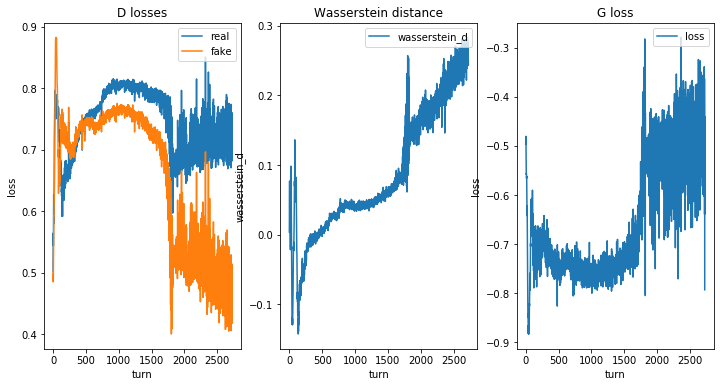

In [15]:
show_status_graph_wgan_gp(status_dict)

500epoch. これは過学習が起きてる？  
生成画像も通常のWGAN-gpの方が良い  
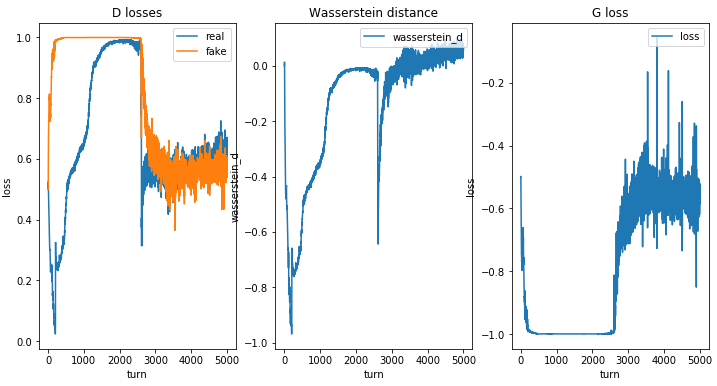
→200にしたからってうまくいくわけではなかった

10:1にしてもべつにうまくいかない  
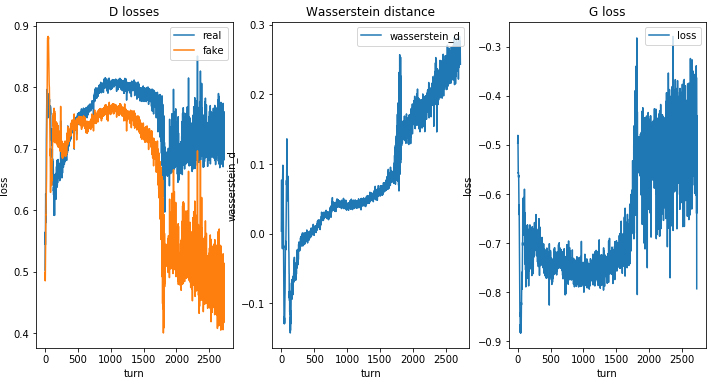

https://qiita.com/hrs1985/items/8bf68254c4b6fa6cd170  
にもあるように，ステップ数を大きくしすぎるのもよくないみたい？  
WDが0付近である状態ををNステップキープ出来たら終了にする？

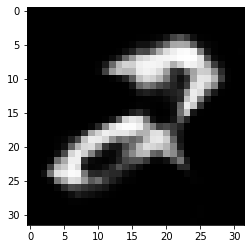

In [22]:
z = torch.randn(config.batch_size, config.latent_dim).to(device)
g_out = G(z)
show_img(g_out.cpu(), 0)